In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/colwyngulliford/Documents/GitHub/lume-gpt/')

In [3]:
import tempfile
import os
import h5py
from time import time
os.getcwd()

'/Users/colwyngulliford/Documents/GitHub/lume-gpt/devel'

In [65]:
from gpt import tools, parsers

In [66]:
class GPT:
    """ 
    GPT simulation object. Essential methods:
    .__init__(...)
    .configure()
    .run()
    
    Input deck is held in .input
    Output data is parsed into .output
    .load_screens() will load particle data into .screen[...]
    
    The GPT binary file can be set on init. If it doesn't exist, configure will check the
        $GPT_BIN
    environmental variable.
    """
    
    def __init__(self,
                 input_file=None,
                 gpt_bin='$GPT_BIN',      
                 use_tempdir=True,
                 workdir=None,
                 verbose=False):
        
        # Save init
        self.original_input_file = input_file
        self.use_tempdir = use_tempdir
        self.workdir = workdir
        if workdir:
            assert os.path.exists(workdir), 'workdir does not exist: '+workdir        
        self.verbose=verbose
        self.gpt_bin = gpt_bin

        # These will be set
        self.log = []
        self.output = {}
        #self.screen = [] # list of screens
        self.timeout=None
        self.error = False
       
        # Run control
        self.finished = False
        self.configured = False
        self.using_tempdir = False
      
        # Call configure
        if input_file:
            self.load_input(input_file)
            self.configure()
        else:
            self.vprint('Warning: Input file does not exist. Not configured.')

    def configure(self):
        self.configure_gpt(workdir=self.workdir)
 
    def configure_gpt(self, input_filePath=None, workdir=None):
        
        if input_filePath:
            self.load_input(input_filePath)
        
        # Check that binary exists
        self.gpt_bin = tools.full_path(self.gpt_bin)
        assert os.path.exists(self.gpt_bin), 'ERROR: GPT binary does not exist:'+self.gpt_bin
              
        # Set paths
        if self.use_tempdir:
            # Need to attach this to the object. Otherwise it will go out of scope.
            self.tempdir = tempfile.TemporaryDirectory(dir=workdir)
            self.path = self.tempdir.name
        else:
            # Work in place
            self.path = self.original_path            

        self.input_file = os.path.join(self.path, self.original_input_file)                
        self.configured = True

    def load_input(self, input_filePath, absolute_paths=True):
        f = tools.full_path(input_filePath)
        self.original_path, self.original_input_file = os.path.split(f) # Get original path, filename
        self.input = parsers.parse_gpt_input_file(f)            
            
    def set_variables(self, variables):
        for var in variables:
            if(var in self.input["variables"]):
                #print(var,variables[var])
                self.input["variables"][var]=variables[var]
    
    def load_output(self):
        touts,screens=parsers.read_gdf_file('gpt.out.gdf')
        
        self.screen = screens
        self.tout = touts
        
        
                
#    def load_screens(self, end_only=False):
#        # Clear existing screens
#        self.screen = []
        
        #TODO
  
    def run(self):
        if not self.configured:
            print('not configured to run')
            return
        pass
        self.run_gpt(verbose=self.verbose, timeout=self.timeout)
        
    def get_run_script(self, write_to_path=True):
        """
        Assembles the run script. Optionally writes a file 'run' with this line to path.
        """
        
        _, infile = os.path.split(self.input_file)
        
        tokens = infile.split('.')
        if(len(tokens)>1):
            outfile = ''.join(tokens[:-1])+'.out.gdf'
        else:
            outfile = tokens[0]+'.out.gdf'
        
        runscript = [self.gpt_bin, '-v -o', outfile, infile]
            
        if write_to_path:
            with open(os.path.join(self.path, 'run'), 'w') as f:
                f.write(' '.join(runscript))
            
        return runscript

    def run_gpt(self, verbose=False, parse_output=True, timeout=None):
        
        run_info = {}
        t1 = time()
        run_info['start_time'] = t1
        
        # Move to local directory
        # Save init dir
        init_dir = os.getcwd()
        self.vprint('init dir: ', init_dir)

        os.chdir(self.path)
        # Debugging
        self.vprint('running GPT in '+os.getcwd())#

        # Write input file from internal dict
        self.write_input_file()
        
        # If there is a fields folder in the original path, soft link to it:
        if(os.path.isdir(self.original_path+'/fields') and not os.path.isdir('fields')):
            os.symlink(self.original_path+'/fields', 'fields')
        
        # If there is a gpt_particles.gdf in original path, soft link to it:
        if(os.path.isfile(self.original_path+'/gpt_particles.gdf') and not os.path.isfile('gpt_particles.gdf')):
            os.symlink(self.original_path+'/gpt_particles.gdf', 'gpt_particles.gdf')
            
        runscript = self.get_run_script()

        try:
            if timeout:
                print("Running with timeout")
                kill_msgs = ["gpt: Spacecharge3Dmesh:", 
                             'Error:','gpt: No valid GPT license']
                
                run_time,exception,log = tools.execute3(runscript, kill_msgs=kill_msgs, timeout=timeout)
                
                if(exception is not None):
                    self.error=True
                    run_info["error"]=True
                    run_info['why_error']=exception
            else:
                # Interactive output, for Jupyter
                log = []
                for path in tools.execute(runscript):
                    self.vprint(path, end="")
                    log.append(path)
    
            self.log = log
                    
            if parse_output:
                self.load_output()
                
        except Exception as ex:
            
            print('Run Aborted:', ex)
            self.error = True
            run_info['why_error'] = str(ex)
            
        finally:
            run_info['run_time'] = time() - t1
            run_info['run_error'] = self.error
            
            # Add run_info
            self.output.update(run_info)
            
            # Return to init_dir
            os.chdir(init_dir)                        
        
        self.finished = True
    
    def fingerprint(self):
        """
        Data fingerprint using the input. 
        """
        return tools.fingerprint(self.input)
                
    def vprint(self, *args, **kwargs):
        # Verbose print
        if self.verbose:
            print(*args, **kwargs)    
    
    def write_input_file(self):
        parsers.write_gpt_input_file(self.input, self.input_file)
        
    # h5 writing
    def write_input(self, h5):
        #TODO
        #writers.write_input_h5(h5, self.input)
        pass
    
#    def write_output(self, h5):
#        #TODO
#        writers.write_output_h5(h5, self.output)
        
#    def write_screens(self, h5):
#        #writers.write_screens_h5(h5, self.screen)    
#        pass
        
#    def archive(self, h5=None):
#        """
#        Archive all data to an h5 handle or filename.
#        
#        If no file is given, a file based on the fingerprint will be created.
        
#        """
#        if not h5:
#            h5 = 'gpt_'+self.fingerprint()+'.h5'
#         
#        if isinstance(h5, str):
#            g = h5py.File(h5, 'w')
#            self.vprint(f'Archiving to file {h5}')
#        else:
#            g = h5
#        
#        # All input
#        self.write_input(g)

#        # All output
#        self.write_output(g)
            
#        # Particles    
#        self.write_screens(g)          
        
#        return h5
        
    
    def __str__(self):

        outstr = "GPT object:"
        outstr = outstr+ "\n   Original input file: "+self.original_input_file
        outstr = outstr+f"\n   Use temp directory: {self.use_tempdir}"
        outstr = outstr+f"\n   Work directory: {self.workdir}"
       
        # Run control
        outstr = outstr+"\n\nRun Control"
        outstr = outstr+f"\n   Run configured: {self.configured}"
        outstr = outstr+f"\n   Using temp directory: {self.using_tempdir}"
        outstr = outstr+f"\n   Finished: {self.finished}"

        # Results
        outstr = outstr+"\n\nResults"
        outstr = outstr+f"\n   Timeout occured: {self.timeout}"
        outstr = outstr+f"\n   Error occured: {self.error}"
        outstr = outstr+f"\n   Log: {self.log}\n"
        return outstr

In [67]:
G = GPT(input_file='/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun/gpt.in',
        workdir='/Users/colwyngulliford/Documents/GitHub/lume-gpt/devel/test')
G.set_variables({'gun_voltage':375,'sol_1_current':-3.8})

In [68]:
G.timeout=10
G.run()

Running with timeout
done


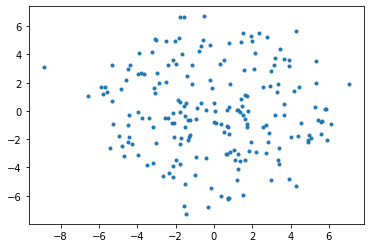

In [70]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(1000*G.screen[-1]['x'],1000*G.screen[-1]['y'],'.')